In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import json
from copy import deepcopy

## Read in data

In [2]:
sofia_data = pd.read_csv("SofiaSensorDataCleaned.csv")

In [3]:
sofia_data['month'] = pd.DatetimeIndex(sofia_data['date']).month_name()

In [4]:
with open("Sofia_GeoMapping.json", "r") as j:
    SofiaGeoMap = json.loads(j.read())

In [5]:
sofia_data

,sensor_id,date,location,lat,lon,PM10,PM2.5,district,district_group,month
0,739,2018-09-21,354.0,42.694,23.337,8.009815,4.999136,Sredets,City Center,September
1,739,2018-09-22,354.0,42.694,23.337,15.673511,10.291997,Sredets,City Center,September
2,739,2018-09-23,354.0,42.694,23.337,26.578480,18.875699,Sredets,City Center,September
3,739,2018-09-24,354.0,42.694,23.337,18.994805,14.145674,Sredets,City Center,September
4,739,2018-09-25,354.0,42.694,23.337,6.395000,5.132836,Sredets,City Center,September
...,...,...,...,...,...,...,...,...,...,...
115458,28130,2019-06-27,15418.0,42.634,23.374,16.595138,9.271741,Mladost,Socialist Housing Districts,June
115459,28130,2019-06-28,15418.0,42.634,23.374,19.338834,11.369863,Mladost,Socialist Housing Districts,June
115460,28130,2019-06-29,15418.0,42.634,23.374,10.872718,5.135366,Mladost,Socialist Housing Districts,June
115461,28130,2019-06-30,15418.0,42.634,23.374,8.674697,4.358009,Mladost,Socialist Housing Districts,June


## Create grouped datasets

In [6]:
def q10(x):
    return x.quantile(0.1)
def q90(x):
    return x.quantile(0.9)

In [7]:
sofia_grouped_all = sofia_data.groupby('district').agg(
    PM2_5_avg = ('PM2.5', 'mean'),
    #PM2_5_std = ('PM2.5', 'std'),
    PM2_5_p10 = ('PM2.5', q10),
    PM2_5_p90 = ('PM2.5', q90),
    N_readings = ('sensor_id', 'count')
)
temp_df = sofia_data.groupby('district')['sensor_id'].nunique().reset_index()
temp_df.columns = ['district', 'N_sensors']
temp_df = temp_df.set_index('district')
sofia_grouped_all = sofia_grouped_all.join(temp_df, on = 'district').reset_index().join(sofia_data.groupby(['district', 'district_group']).size().reset_index().drop(0, axis = 1).set_index('district'), on = 'district')
del temp_df

In [8]:
sofia_grouped_all

,district,PM2_5_avg,PM2_5_p10,PM2_5_p90,N_readings,N_sensors,district_group
0,Ilinden,15.794657,5.946569,28.444759,1040,4,Early to Mid 20th Century Districts
1,Iskar,13.169579,4.926829,24.832670,2976,13,Socialist Housing Districts
2,Izgrev,12.993820,4.401438,24.319190,3329,13,Early to Mid 20th Century Districts
3,Krasna Polyana,15.685596,4.073352,30.960165,4356,14,Early to Mid 20th Century Districts
4,Krasno selo,13.504009,4.250915,25.610930,6833,24,Early to Mid 20th Century Districts
5,Kremikovetsi,14.953292,6.320005,27.379107,329,2,Industrial District
6,Lozenets,13.642697,4.688085,24.771523,6990,31,Early to Mid 20th Century Districts
7,Lyulin,13.146412,4.479979,25.579117,3432,13,Socialist Housing Districts
8,Mladost,11.804386,3.834795,21.846792,13087,46,Socialist Housing Districts
9,Nadezhda,14.657936,4.920901,28.091676,3056,11,Socialist Housing Districts


In [9]:
sofia_grouped_mo = sofia_data.groupby(['district', 'month']).agg(
    PM2_5_avg = ('PM2.5', 'mean'),
    #PM2_5_std = ('PM2.5', 'std'),
    PM2_5_p10 = ('PM2.5', q10),
    PM2_5_p90 = ('PM2.5', q90),
    N_readings = ('sensor_id', 'count')
)
temp_df = sofia_data.groupby(['district', 'month'])['sensor_id'].nunique().reset_index()
temp_df.columns = ['district', 'month', 'N_sensors']
temp_df = temp_df.set_index(['district', 'month'])
sofia_grouped_mo = sofia_grouped_mo.join(temp_df, on = ['district', 'month']).reset_index().join(sofia_data.groupby(['district', 'district_group']).size().reset_index().drop(0, axis = 1).set_index('district'), on = 'district')
del temp_df

In [10]:
sofia_grouped_mo

,district,month,PM2_5_avg,PM2_5_p10,PM2_5_p90,N_readings,N_sensors,district_group
0,Ilinden,April,11.593931,4.973995,17.965574,88,3,Early to Mid 20th Century Districts
1,Ilinden,August,10.643474,5.234317,15.779895,93,3,Early to Mid 20th Century Districts
2,Ilinden,December,29.550073,9.025394,71.224706,95,4,Early to Mid 20th Century Districts
3,Ilinden,February,18.790859,7.018042,34.841133,66,3,Early to Mid 20th Century Districts
4,Ilinden,January,22.660048,9.068151,40.116874,92,3,Early to Mid 20th Century Districts
...,...,...,...,...,...,...,...,...
271,Vrabnits,March,13.217520,3.934034,21.933965,244,8,Peripheral Districts
272,Vrabnits,May,6.311719,1.924486,11.862429,201,8,Peripheral Districts
273,Vrabnits,November,25.239144,9.391556,42.180942,253,9,Peripheral Districts
274,Vrabnits,October,14.600476,7.305985,24.710947,275,9,Peripheral Districts


In [11]:
mo_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [12]:
df_mo_dict = {}
for mo in mo_list:
    df_mo_dict[mo] = sofia_grouped_mo[sofia_grouped_mo['month'] == mo].reset_index(drop = True)

In [13]:
df_mo_dict

{'January':           district    month  PM2_5_avg  PM2_5_p10  PM2_5_p90  N_readings  \
 0          Ilinden  January  22.660048   9.068151  40.116874          92   
 1            Iskar  January  22.521866   8.701971  39.076847         220   
 2           Izgrev  January  20.798637   6.176778  40.575883         278   
 3   Krasna Polyana  January  26.918884  10.473689  47.637778         364   
 4      Krasno selo  January  22.379421   7.388134  45.063076         598   
 5     Kremikovetsi  January  24.253988  10.917002  41.931935          31   
 6         Lozenets  January  20.521947   5.724902  42.304370         581   
 7           Lyulin  January  21.164072   7.383726  41.612350         279   
 8          Mladost  January  18.412650   6.473583  35.017320        1192   
 9         Nadezhda  January  22.767087   8.858971  40.807336         241   
 10      Novi Iskar  January  23.468439   8.096347  41.082194         112   
 11       Oborishte  January  24.444504   8.855069  43.498775    

In [14]:
geomap_dict = {}
for mo in mo_list:
    geomap_dict[mo] = deepcopy(SofiaGeoMap)

## Create full dataset mapping

In [15]:
list(sofia_grouped_all.columns)

['district',
 'PM2_5_avg',
 'PM2_5_p10',
 'PM2_5_p90',
 'N_readings',
 'N_sensors',
 'district_group']

In [16]:
for s in SofiaGeoMap['features']:
    
    if s['id'] == "Bankya":
        s['properties']['PM2_5_avg'] = "N/A"
        s['properties']['PM2_5_p10'] = "N/A"
        s['properties']['PM2_5_p90'] = "N/A"
        s['properties']['N_readings'] = "0"
        s['properties']['N_sensors'] = "0"
        s['properties']['district_group'] = "Peripheral Districts"
    
    else:
        s['properties']['PM2_5_avg'] = str(round(float(sofia_grouped_all[sofia_grouped_all['district'] == s['id']]['PM2_5_avg']), 2)) + " μg/m^3"
        s['properties']['PM2_5_p10'] = str(round(float(sofia_grouped_all[sofia_grouped_all['district'] == s['id']]['PM2_5_p10']), 2)) + " μg/m^3"
        s['properties']['PM2_5_p90'] = str(round(float(sofia_grouped_all[sofia_grouped_all['district'] == s['id']]['PM2_5_p90']), 2)) + " μg/m^3"
        s['properties']['N_readings'] = str(int(sofia_grouped_all[sofia_grouped_all['district'] == s['id']]['N_readings']))
        s['properties']['N_sensors'] = str(int(sofia_grouped_all[sofia_grouped_all['district'] == s['id']]['N_sensors']))
        s['properties']['district_group'] = list(sofia_grouped_all[sofia_grouped_all['district'] == s['id']]['district_group'])[0]

In [17]:
for mo in mo_list:
    df_temp = df_mo_dict[mo]
    for s in geomap_dict[mo]['features']:
        


        if s['id'] == "Bankya":
            s['properties']['PM2_5_avg'] = "N/A"
            s['properties']['PM2_5_p10'] = "N/A"
            s['properties']['PM2_5_p90'] = "N/A"
            s['properties']['N_readings'] = "0"
            s['properties']['N_sensors'] = "0"
            s['properties']['district_group'] = "Peripheral Districts"

        else:
            s['properties']['PM2_5_avg'] = str(round(float(df_temp[df_temp['district'] == s['id']]['PM2_5_avg']), 2)) + " μg/m^3"
            s['properties']['PM2_5_p10'] = str(round(float(df_temp[df_temp['district'] == s['id']]['PM2_5_p10']), 2)) + " μg/m^3"
            s['properties']['PM2_5_p90'] = str(round(float(df_temp[df_temp['district'] == s['id']]['PM2_5_p90']), 2)) + " μg/m^3"
            s['properties']['N_readings'] = str(int(df_temp[df_temp['district'] == s['id']]['N_readings']))
            s['properties']['N_sensors'] = str(int(df_temp[df_temp['district'] == s['id']]['N_sensors']))
            s['properties']['district_group'] = list(df_temp[df_temp['district'] == s['id']]['district_group'])[0]
           
        if s['id'] == 'Sredets':
            print(mo, s['id'], s['properties']['PM2_5_avg'])
            
del df_temp

January Sredets 22.86 μg/m^3
February Sredets 18.55 μg/m^3
March Sredets 13.97 μg/m^3
April Sredets 11.47 μg/m^3
May Sredets 8.07 μg/m^3
June Sredets 10.35 μg/m^3
July Sredets 10.31 μg/m^3
August Sredets 9.1 μg/m^3
September Sredets 8.3 μg/m^3
October Sredets 11.87 μg/m^3
November Sredets 20.11 μg/m^3
December Sredets 26.13 μg/m^3


In [18]:
import branca.colormap as cmp
PM25_CM = cmp.LinearColormap(
    ['white', 'yellow', 'orange', 'red', 'black'],
    vmin = 0, 
    vmax = 50,
    caption='Color Scale for Map' #Caption for Color scale or Legend
)
PM25_CM

In [19]:
from folium.plugins import StripePattern

In [20]:
m = folium.Map(location = [42.69, 23.35], zoom_start = 11, tiles = None)
folium.TileLayer('openstreetmap',
                control = False).add_to(m)

In [21]:
#tile_layer = folium.TileLayer(
#    tiles='http://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
#    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
#    max_zoom=19,
#    name='voyager',
#    control=False,
#    opacity=1
#)
#tile_layer.add_to(m)

cp = folium.Choropleth(
    geo_data=SofiaGeoMap,
    name="Avg PM2.5",
    legend_name = 'PM2.5 (μg/m^3)',
    data=sofia_grouped_all,
    columns= ['district', 'PM2_5_avg'],
    key_on="feature.id",
    fill_color= "YlOrRd",
    nan_fill_color = "white",
    line_color = 'black',
    fill_opacity=0.7,
    line_opacity=0.5,
    highlight = True,
    bins = np.linspace(5, 31, 10),
    overlay = False
).add_to(m)

#sp = StripePattern(angle=45, color='grey', space_color='white')
#sp.add_to(m)



# adding the nan layer with `sp` as the fillPattern
#folium.GeoJson(data=sofia_grouped_all, style_function=lambda x :{'fillPattern': sp}).add_to(m)

cp2 = folium.Choropleth(
    geo_data=SofiaGeoMap,
    name="PM2.5 - 10th Percentile",
    data=sofia_grouped_all,
    columns= ['district', 'PM2_5_p10'],
    key_on="feature.id",
    fill_color="YlOrRd",
    nan_fill_color = "white",
    line_color = 'black',
    fill_opacity=0.7,
    line_opacity=0.5,
    highlight = True,
    bins = np.linspace(0, 31, 10),
    overlay = False
).add_to(m)
#
#cp3 = folium.Choropleth(
#    geo_data=SofiaGeoMap,
#    name="PM2.5 - 90th Percentile",
#    data=sofia_grouped_all,
#    columns= ['district', 'PM2_5_p90'],
#    key_on="feature.id",
#    fill_color="YlOrRd",
#    nan_fill_color = "white",
#    line_color = 'black',
#    fill_opacity=0.7,
#    line_opacity=0.5,
#    highlight = True,
#    bins = np.linspace(5, 24, 10)
#).add_to(m)

#cp4 = folium.Choropleth(
#    geo_data=SofiaGeoMap,
#    name="District Grouping Lines",
#    data=sofia_grouped_all,
#    columns= ['district', 'district_group'],
#    key_on="feature.id",
#    line_color = 'black',
#    fill_color = 'YlOrRd',
#    fill_opacity=0,
#    line_opacity=1
#).add_to(m)


folium.GeoJsonTooltip(['name', 'district_group'] + list(sofia_grouped_all.columns[1:-1]), aliases = ['District:', 'District Group:', 'Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(sofia_grouped_all.columns[1:-1]), aliases = ['District:', 'District Group:', 'Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp2.geojson)
#folium.GeoJsonTooltip(['name', 'district_group'] + list(sofia_grouped_all.columns[1:-1]), aliases = ['District:', 'District Group:', 'Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp3.geojson)

folium.LayerControl().add_to(m)

In [22]:
m

In [23]:
sofia_grouped_all

,district,PM2_5_avg,PM2_5_p10,PM2_5_p90,N_readings,N_sensors,district_group
0,Ilinden,15.794657,5.946569,28.444759,1040,4,Early to Mid 20th Century Districts
1,Iskar,13.169579,4.926829,24.832670,2976,13,Socialist Housing Districts
2,Izgrev,12.993820,4.401438,24.319190,3329,13,Early to Mid 20th Century Districts
3,Krasna Polyana,15.685596,4.073352,30.960165,4356,14,Early to Mid 20th Century Districts
4,Krasno selo,13.504009,4.250915,25.610930,6833,24,Early to Mid 20th Century Districts
5,Kremikovetsi,14.953292,6.320005,27.379107,329,2,Industrial District
6,Lozenets,13.642697,4.688085,24.771523,6990,31,Early to Mid 20th Century Districts
7,Lyulin,13.146412,4.479979,25.579117,3432,13,Socialist Housing Districts
8,Mladost,11.804386,3.834795,21.846792,13087,46,Socialist Housing Districts
9,Nadezhda,14.657936,4.920901,28.091676,3056,11,Socialist Housing Districts


### Months

In [29]:
m = folium.Map(location = [42.66, 23.35], 
               zoom_start = 11, 
               tiles = None)
folium.TileLayer('openstreetmap',
                control = False).add_to(m)

In [30]:
def monthly_choro(month):
    
    cp_mo = folium.Choropleth(
        geo_data=geomap_dict[month],
        name=month,
        data=df_mo_dict[month],
        columns= ['district', 'PM2_5_avg'],
        key_on="feature.id",
        fill_color= "YlOrRd",
        nan_fill_color = "white",
        line_color = 'black',
        fill_opacity=0.7,
        line_opacity=0.5,
        highlight = True,
        bins = np.linspace(5, 31, 10),
        overlay = False
    )

    for key in cp_mo._children:
        if key.startswith('color_map'):
            del(cp_mo._children[key])

    return cp_mo

cp_full = folium.Choropleth(
    geo_data=SofiaGeoMap,
    name="Full Year",
    legend_name = 'Daily Average PM2.5 (μg/m^3)',
    data=sofia_grouped_all,
    columns= ['district', 'PM2_5_avg'],
    key_on="feature.id",
    fill_color= "YlOrRd",
    nan_fill_color = "white",
    line_color = 'black',
    fill_opacity=0.7,
    line_opacity=0.5,
    highlight = True,
    bins = np.linspace(5, 31, 10),
    overlay = False
).add_to(m)
    
cp_jan = monthly_choro(mo_list[0]).add_to(m)
cp_feb = monthly_choro(mo_list[1]).add_to(m)
cp_mar = monthly_choro(mo_list[2]).add_to(m)
cp_apr = monthly_choro(mo_list[3]).add_to(m)
cp_may = monthly_choro(mo_list[4]).add_to(m)
cp_jun = monthly_choro(mo_list[5]).add_to(m)
cp_jul = monthly_choro(mo_list[6]).add_to(m)
cp_aug = monthly_choro(mo_list[7]).add_to(m)
cp_sep = monthly_choro(mo_list[8]).add_to(m)
cp_oct = monthly_choro(mo_list[9]).add_to(m)
cp_nov = monthly_choro(mo_list[10]).add_to(m)
cp_dec = monthly_choro(mo_list[11]).add_to(m)


folium.GeoJsonTooltip(['name', 'district_group'] + list(sofia_grouped_all.columns[1:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_full.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[0]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_jan.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[1]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_feb.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[2]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_mar.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[3]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_apr.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[4]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_may.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[5]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_jun.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[6]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_jul.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[7]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_aug.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[8]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_sep.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[9]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_oct.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[10]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_nov.geojson)
folium.GeoJsonTooltip(['name', 'district_group'] + list(df_mo_dict[mo_list[11]].columns[2:-1]), aliases = ['District:', 'District Group:', 'Daily Avg PM 2.5:', '10th Percentile:', '90th Percentile:', 'Total Daily Readings:', 'Unique Sensors:']).add_to(cp_dec.geojson)


#image_file = 'dg_testing.png'
#
#FloatImage(image_file, bottom=1, left=1).add_to(m)

folium.LayerControl('topright', collapsed = False).add_to(m)

In [31]:
#from folium.plugins import FloatImage
#image_file = 'dg_testing.png'
#
#FloatImage(image_file, bottom=1, left=1).add_to(m)

In [32]:
m

In [33]:
m.save("MonthlyMapTest.html")

In [976]:
sofia_grouped_mo[sofia_grouped_mo['district'] == 'Sredets']

,district,month,PM2_5_avg,PM2_5_p10,PM2_5_p90,N_readings,N_sensors,district_group
204,Sredets,April,11.472572,3.848862,18.098152,223,8,City Center
205,Sredets,August,9.096135,3.112656,15.761431,197,8,City Center
206,Sredets,December,26.132022,9.054508,66.547037,121,6,City Center
207,Sredets,February,18.549669,5.162066,33.714151,168,6,City Center
208,Sredets,January,22.863153,9.427139,39.518747,144,6,City Center
209,Sredets,July,10.312653,4.016701,16.010491,226,9,City Center
210,Sredets,June,10.354118,6.273362,15.014374,219,8,City Center
211,Sredets,March,13.972201,7.723112,19.799458,194,8,City Center
212,Sredets,May,8.074332,3.757853,13.305881,201,9,City Center
213,Sredets,November,20.106491,3.936907,38.455334,178,8,City Center


In [997]:
df_mo_dict['May']

,district,month,PM2_5_avg,PM2_5_p10,PM2_5_p90,N_readings,N_sensors,district_group
0,Ilinden,May,8.429140,4.024948,13.347735,92,3,Early to Mid 20th Century Districts
1,Iskar,May,7.138926,3.278839,11.689536,303,11,Socialist Housing Districts
2,Izgrev,May,6.872726,2.771324,11.591006,308,10,Early to Mid 20th Century Districts
3,Krasna Polyana,May,7.040257,1.435419,12.994818,413,14,Early to Mid 20th Century Districts
4,Krasno selo,May,6.960708,2.739178,11.843933,639,21,Early to Mid 20th Century Districts
5,Kremikovetsi,May,6.709934,3.561029,11.241309,30,1,Industrial District
6,Lozenets,May,7.131049,2.616877,12.299058,621,23,Early to Mid 20th Century Districts
7,Lyulin,May,6.308495,2.396956,10.859314,363,12,Socialist Housing Districts
8,Mladost,May,6.906559,2.644146,12.053746,1184,41,Socialist Housing Districts
9,Nadezhda,May,6.981216,3.027697,11.939779,253,9,Socialist Housing Districts


In [996]:
sofia_grouped_all

,district,PM2_5_avg,PM2_5_p10,PM2_5_p90,N_readings,N_sensors,district_group
0,Ilinden,15.794657,5.946569,28.444759,1040,4,Early to Mid 20th Century Districts
1,Iskar,13.169579,4.926829,24.832670,2976,13,Socialist Housing Districts
2,Izgrev,12.993820,4.401438,24.319190,3329,13,Early to Mid 20th Century Districts
3,Krasna Polyana,15.685596,4.073352,30.960165,4356,14,Early to Mid 20th Century Districts
4,Krasno selo,13.504009,4.250915,25.610930,6833,24,Early to Mid 20th Century Districts
5,Kremikovetsi,14.953292,6.320005,27.379107,329,2,Industrial District
6,Lozenets,13.642697,4.688085,24.771523,6990,31,Early to Mid 20th Century Districts
7,Lyulin,13.146412,4.479979,25.579117,3432,13,Socialist Housing Districts
8,Mladost,11.804386,3.834795,21.846792,13087,46,Socialist Housing Districts
9,Nadezhda,14.657936,4.920901,28.091676,3056,11,Socialist Housing Districts


In [40]:
import datetime

In [46]:
df_plots = sofia_grouped_mo.copy()
df_plots['month_num'] = [datetime.datetime.strptime(sofia_grouped_mo['month'][i], "%B").month for i in range(sofia_grouped_mo.shape[0])]

In [47]:
df_plots

,district,month,PM2_5_avg,PM2_5_p10,PM2_5_p90,N_readings,N_sensors,district_group,month_num
0,Ilinden,April,11.593931,4.973995,17.965574,88,3,Early to Mid 20th Century Districts,4
1,Ilinden,August,10.643474,5.234317,15.779895,93,3,Early to Mid 20th Century Districts,8
2,Ilinden,December,29.550073,9.025394,71.224706,95,4,Early to Mid 20th Century Districts,12
3,Ilinden,February,18.790859,7.018042,34.841133,66,3,Early to Mid 20th Century Districts,2
4,Ilinden,January,22.660048,9.068151,40.116874,92,3,Early to Mid 20th Century Districts,1
...,...,...,...,...,...,...,...,...,...
271,Vrabnits,March,13.217520,3.934034,21.933965,244,8,Peripheral Districts,3
272,Vrabnits,May,6.311719,1.924486,11.862429,201,8,Peripheral Districts,5
273,Vrabnits,November,25.239144,9.391556,42.180942,253,9,Peripheral Districts,11
274,Vrabnits,October,14.600476,7.305985,24.710947,275,9,Peripheral Districts,10


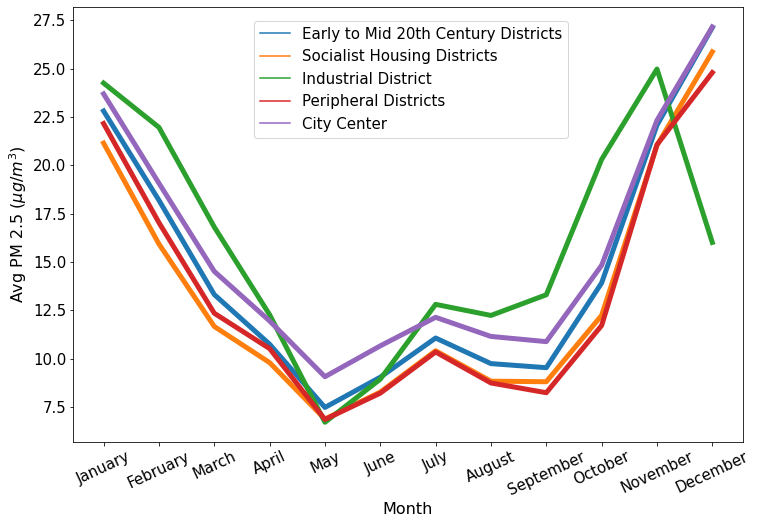

In [148]:
plt.figure(figsize = (12, 8))
sns.lineplot(x = 'month_num', y = 'PM2_5_avg', hue = 'district_group', data = df_plots, ci = None, linewidth = 5)
plt.xlabel('Month', size = 16)
plt.ylabel(r'Avg PM 2.5 ($\mu g/m^3$)', size = 16)
plt.xticks(range(1, 13), mo_list, rotation = 25, size = 15)
plt.yticks(size = 15)
plt.legend(loc = (0.27,0.7), fontsize = 15)
plt.savefig('dg_testing.png', dpi = 40)
plt.show()

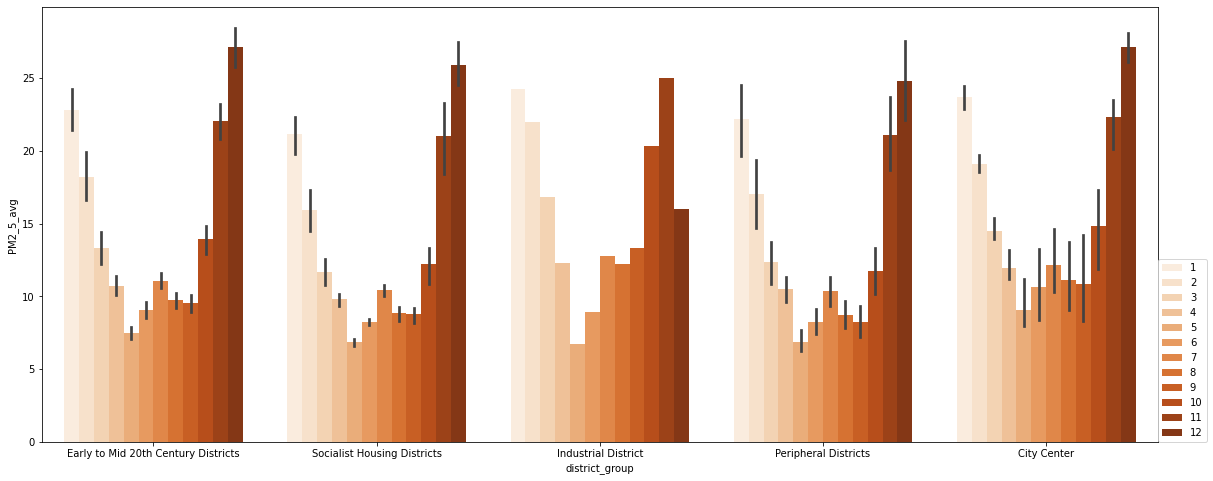

In [72]:
plt.figure(figsize = (20, 8))
sns.barplot(x = 'district_group', y = 'PM2_5_avg', hue = 'month_num', palette = 'Oranges', data = df_plots)
#plt.xticks(range(1, 13), mo_list, rotation = 25)
plt.legend(loc = (1,0))
plt.show()